In [1]:
from scipy import stats
import arviz as az
import pymc as pm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

Two paths forward here for testing the bayesian bioreactor model
1. experiment data, cut to batch phase
2. data generated from a growth/death logistic model with some normally distributed noise.

# Experimental Data

In [ ]:
df = pd.read_csv('data/755_vis_10min.csv')
df.head()

# Generated Data

In [85]:
# input parameters

EXPERIMENT_DURATION_HOURS = 40
MODEL_GROWTH_RATE = 0.4
MODEL_MAX_BIOMASS = 20
MODEL_INITIAL_BIOMASS = 0.01

MODEL_NOISE_SIGMA = 1

time = np.arange(EXPERIMENT_DURATION_HOURS)

In [3]:
def logistic_growth(
        time: np.ndarray,
        initial_biomass: float,
        max_biomass: float,
        growth_rate: float
        ) -> list:
        
    biomass = max_biomass / (1 + ((max_biomass - initial_biomass) / initial_biomass) * np.exp(-growth_rate * time))

    return biomass

def logistic_growth_gaussian_noise(
        time: np.ndarray,
        initial_biomass: float,
        max_biomass: float,
        growth_rate: float,
        noise_sigma) -> list:
    
    biomass = max_biomass / (1 + ((max_biomass - initial_biomass) / initial_biomass) * np.exp(-growth_rate * time))
    biomass = np.random.normal(loc=biomass, scale=noise_sigma)

    return biomass

def cultivation_experiment(time: np.ndarray, replicates: int) -> pd.DataFrame:
    
    cultivations = [f'run_{i + 1}' for i in range(replicates)]
    frames = []

    for c in cultivations:
        
        biomass = logistic_growth_gaussian_noise(
            time,
            MODEL_INITIAL_BIOMASS,
            MODEL_MAX_BIOMASS,
            MODEL_GROWTH_RATE,
            MODEL_NOISE_SIGMA
            )

        df_dict = {
            'experiment_id': [c for n in range(len(biomass))],
            'time': time,
            'biomass': biomass
        }
        df = pd.DataFrame(df_dict)
        frames.append(df)

    return pd.concat(frames)

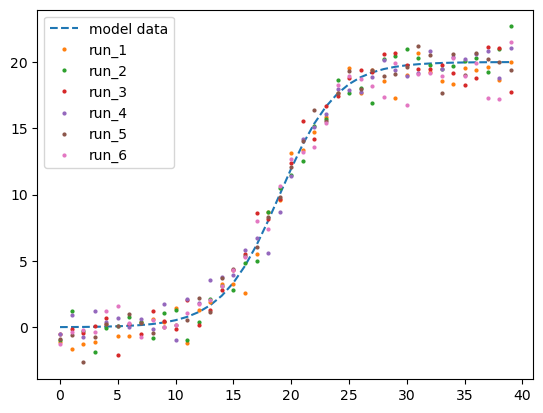

In [94]:
biomass_model_data = logistic_growth(
    time,
    MODEL_INITIAL_BIOMASS,
    MODEL_MAX_BIOMASS,
    MODEL_GROWTH_RATE
)

experiment_data = cultivation_experiment(time=time, replicates=6)

plt.plot(time, biomass_model_data, '--', label='model data')

for id in experiment_data['experiment_id'].unique():
    data = experiment_data.loc[experiment_data['experiment_id'] == id]
    plt.plot(data['time'], data['biomass'], 'o', markersize=2, label=id)

plt.legend()

In [95]:
with pm.Model() as logistic_growth_model:
    # defining priors
    initial_biomass = pm.Normal('initial_biomass', mu=MODEL_INITIAL_BIOMASS, sigma=0.01)
    max_biomass = pm.Uniform('max_biomass', lower=10, upper=40)
    growth_rate = pm.Uniform('growth_rate', lower=0.05, upper=1)

    biomass_sigma = pm.HalfNormal('sigma_biomass', sigma=MODEL_NOISE_SIGMA)

    # Likelihood function for biomass
    biomass = pm.Normal('biomass', mu=logistic_growth(experiment_data['time'], MODEL_INITIAL_BIOMASS, max_biomass, growth_rate), sigma=biomass_sigma, observed=experiment_data['biomass'])
    trace = pm.sample(1000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [initial_biomass, max_biomass, growth_rate, sigma_biomass]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [96]:
trace.extend(pm.sample_prior_predictive(model=logistic_growth_model))
pm.sample_posterior_predictive(trace, extend_inferencedata=True, model=logistic_growth_model)

Sampling: [biomass, growth_rate, initial_biomass, max_biomass, sigma_biomass]
Sampling: [biomass]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
initial_biomass   0.010  0.010  -0.008    0.030      0.000    0.000    6412.0   
max_biomass      19.698  0.108  19.502   19.909      0.002    0.001    4238.0   
growth_rate       0.402  0.002   0.398    0.405      0.000    0.000    4397.0   
sigma_biomass     0.982  0.045   0.899    1.067      0.001    0.000    5752.0   

                 ess_tail  r_hat  
initial_biomass    3386.0    1.0  
max_biomass        3154.0    1.0  
growth_rate        3203.0    1.0  
sigma_biomass      3312.0    1.0  


<Axes: xlabel='biomass / biomass'>

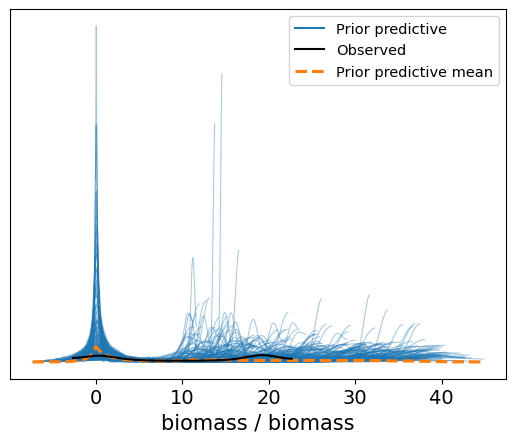

In [97]:
print(az.summary(trace))
az.plot_ppc(trace, observed=True, mean=True, group='prior', alpha=0.4)

<Axes: xlabel='biomass / biomass'>

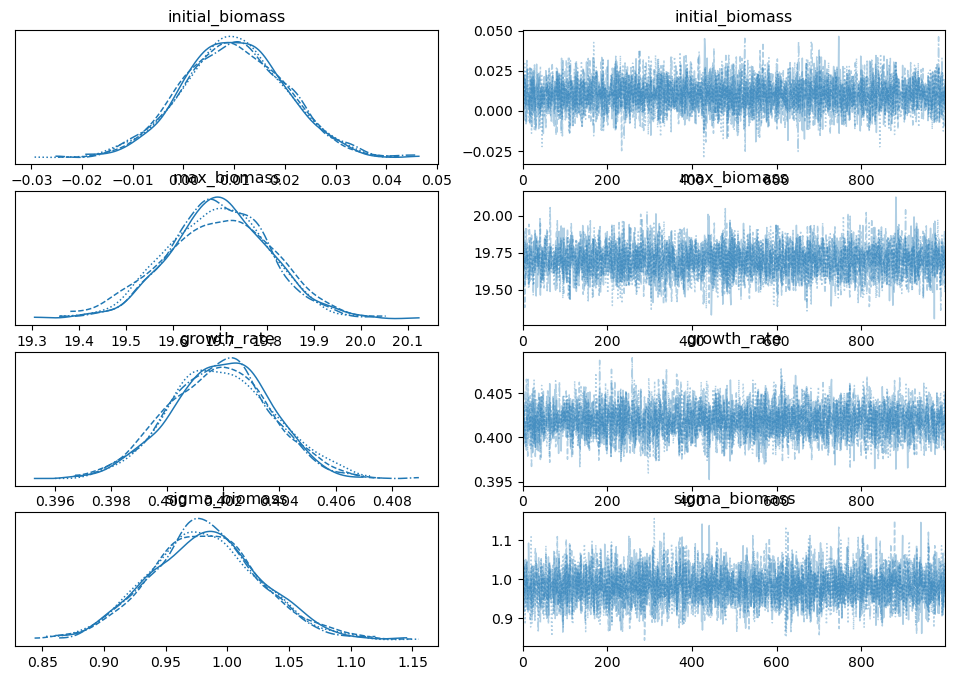

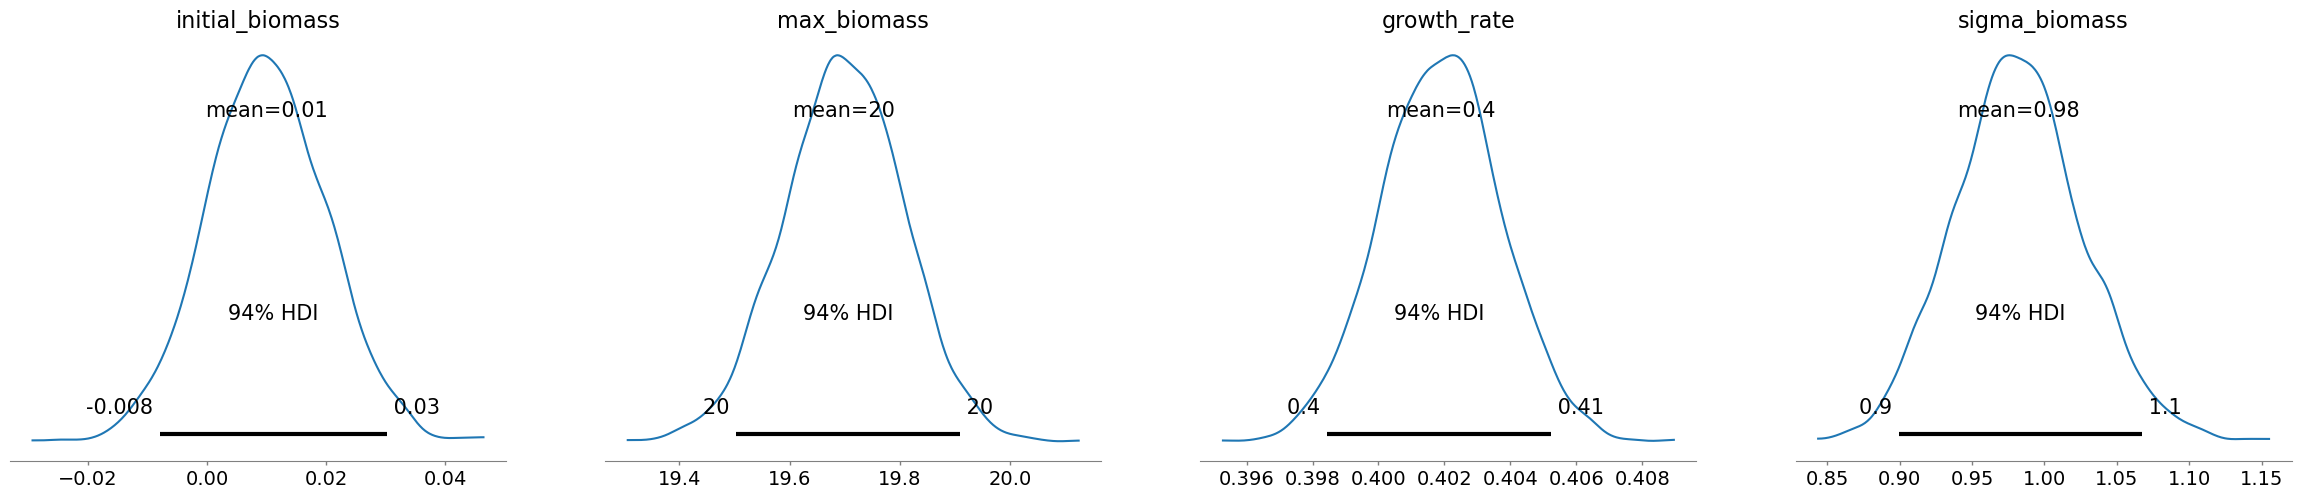

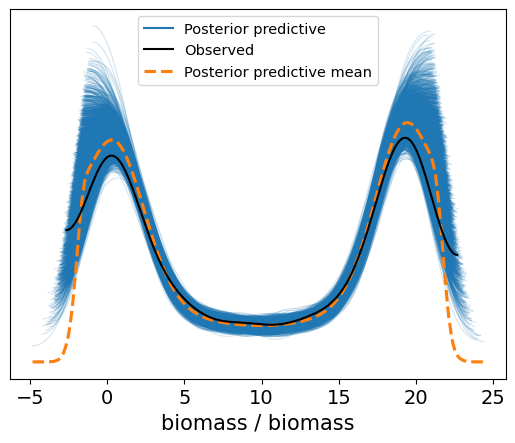

In [98]:
az.plot_trace(trace, divergences=None)
az.plot_posterior(trace, kind='kde')

az.plot_ppc(trace, kind='kde')

In [99]:
post_predictive = trace.posterior_predictive

crit_l = np.percentile(post_predictive["biomass"], q=5, axis=(0, 1))  # grab lower 2.5% quantiles
crit_u = np.percentile(post_predictive["biomass"], q=95, axis=(0, 1))  # grab Upper 92.5% quantiles
mean_spp = np.mean(post_predictive["biomass"], axis=(0, 1)) # Median

credible_int_dict = {
            'experiment_id': experiment_data['experiment_id'],
            'time': experiment_data['time'],
            'lower_int_biomass': crit_l,
            'upper_int_biomass': crit_u
        }

mean_spp_dict = {
            'experiment_id': experiment_data['experiment_id'],
            'time': experiment_data['time'],
            'biomass': mean_spp
        }

credible_int_df = pd.DataFrame(credible_int_dict)
mean_spp_df = pd.DataFrame(mean_spp_dict)

credible_int_df = credible_int_df.groupby(['time']).mean(['lower_int_biomass', 'upper_int_biomass']).reset_index()
mean_spp_df = mean_spp_df.groupby(['time']).mean('biomass').reset_index()

print(crit_l.shape)
print(crit_u.shape)
print(mean_spp.shape)

(240,)
(240,)
(240,)


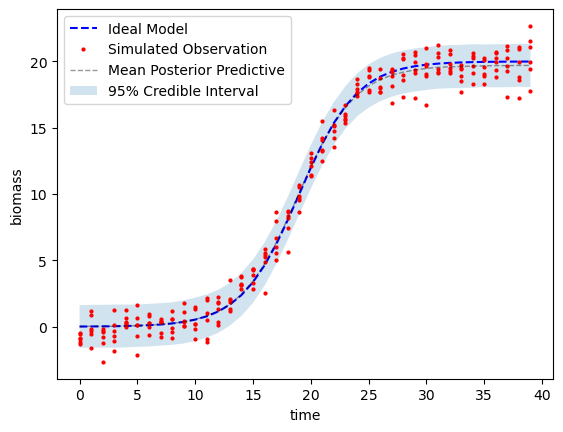

In [100]:
plt.plot(time, biomass_model_data, 'b--', label='Ideal Model')
plt.plot(experiment_data['time'], experiment_data['biomass'], 'ro', markersize=2, label='Simulated Observation')
plt.plot(mean_spp_df['time'], mean_spp_df['biomass'], 'k--', alpha=0.4, linewidth=1, label='Mean Posterior Predictive')
plt.fill_between(credible_int_df['time'], y1=credible_int_df['lower_int_biomass'], y2=credible_int_df['upper_int_biomass'], alpha=0.2, label='95% Credible Interval')

plt.ylabel('biomass')
plt.xlabel('time')
plt.legend()

##SERIOUS PROGRESS!

Got over some syntax hurdles and got to some technical questions with the method I was applying. 

Links: 
https://towardsdatascience.com/pymc3-and-bayesian-inference-for-parameter-uncertainty-quantification-towards-non-linear-models-d1d50250f16a
https://towardsdatascience.com/pymc3-and-bayesian-inference-for-parameter-uncertainty-quantification-towards-non-linear-models-a03c3303e6fa

Notes on application of this method:
1. Method and example data assume a single measurement at each timepoint, what about multiple measurements (say 2 different thermometers in the cooling mug example)?
2. when including multiple measurements, say 3 replicates over 40 hours, that gives me 120 data points in my vector. The model fits this very well, 
    but cannot reconcile that data point 0 and 40 are the same and represent some error inherent to the model. 
    When calculating means and confidence interval, I'm summarizing over the chains and draws but need to make some assumption about how to aggregate the 120 time points to 40 time points (for example)
    Current example 080723, I'm taking the mean of the replicates for each metric...which may be close, but seems technically incorrect
3. All examples I've seen that solve this try to linearize the model and performs a dot product against some "design vector" --- still unsure what this means in this case, or any case for that matter...
4. Dynamic Modeling and Bayesian Forcasting. That's what we're doing, found some really good resources, one using immune response to a drug over time, which is very applicable to the cell growth case,
    this references a book that is a really good option for these specific methods. Good stuff. 
5. Still a lot to learn about the underlying MCMC and some references are mentioning alternative methods ("ABC" -- Approximate Bayesian Compuation??), so is PyMC the right choice?
    https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/samplers/SMC-ABC_Lotka-Volterra_example.html ... just google it!
6. Reading is taking me to ODE solvers. Another approach to aspects of this will be using an ODE solver (an optimized library made by professionals...I should probably be implementing this in more places anyway)
    https://github.com/pymc-devs/sunode
    
    references are getting stored in the ./literature directory



In [ ]:
def biomass_model(
    time,
    state: pd.DataFrame,
    system: pd.DataFrame
    ) -> list:

    frame = pd.DataFrame(columns=state.index)

    frame.iloc[0] = state

    for t in time:
        frame.loc[t + 1], system = update(frame.loc[t])

    return frame, system

def update(state)
    biomass = 0
    substrate = 0

    return pd.DataFrame({
        'time': time,
        'biomass': biomass,
        'substrate': substrate
    })

In [4]:
text = 'Fermentation Process Monitoring and Control | Data Analysis and Interpretation | Project Management | Cross-functional Collaboration | Laboratory Operations | High-throughput Workflows | Equipment Qualification | Laboratory Automation | Risk Assessment | Experimental Design | Media Development and Optimization | Data Automation | Discrepancy Management, RCA and CAPA | Git | Astronomer and Apache Airflow'
text = text.replace(' | ', ', ')
print(text)

Fermentation Process Monitoring and Control, Data Analysis and Interpretation, Project Management, Cross-functional Collaboration, Laboratory Operations, High-throughput Workflows, Equipment Qualification, Laboratory Automation, Risk Assessment, Experimental Design, Media Development and Optimization, Data Automation, Discrepancy Management, RCA and CAPA, Git, Astronomer and Apache Airflow
